### Presidential candidate tweet analysis
How do different presidential candidates utilize their twitter accounts? What topics do they talk about and how do they talk about these topics?

### Table of Contents  
[1. Import data](#1)  
[2. Exploratory data analysis](#2)  
[3. Add features](#3)  
[4. Tf-idf/cluster](#4)  
[5. Kmeans clustering](#5)  
[6. LDA](#6)

In [345]:
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
from textblob import TextBlob as blob
from scipy import stats
from pymongo import MongoClient

# sentiment analysis
from textblob.sentiments import NaiveBayesAnalyzer
from pattern.en import sentiment, mood, modality, wordnet, ADJECTIVE

# text parsing
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from spacy.en import English, STOPWORDS
from nltk.tokenize import sent_tokenize, word_tokenize

# modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.cluster import KMeans
import lda
from sklearn.decomposition import PCA, LatentDirichletAllocation

# visualization
import pyLDAvis

%matplotlib inline

### <a id='1'></a> 1. Import data and convert to df

In [105]:
# define mongodb parameters
client = MongoClient()
db = client.tweets

coll_dict = {'trump': db.trump, 
             'clinton' : db.clinton, 
             'sanders' : db.sanders, 
             'cruz' : db.cruz, 
             'rubio' : db.rubio}

def into_mongo(collection, results):
    coll = collection
    for tweet in results:
        coll.insert_one(tweet)
        
def out_of_mongo(collection):
    tweet_list = []
    for tweet in collection.find():
        tweet_list.append(tweet)
    return tweet_list

In [113]:
dt_data = out_of_mongo(coll_dict['trump'])
hc_data = out_of_mongo(coll_dict['clinton'])
bs_data = out_of_mongo(coll_dict['sanders'])
tc_data = out_of_mongo(coll_dict['cruz'])
mr_data = out_of_mongo(coll_dict['rubio'])

In [114]:
def data_to_df(data, name):
    """Convert list object of tweet data into dataframe; keep only important columns.
    Args:
    data (list of dict, json) -- tweet data
    name (string) -- name of candidate, used to populate candidate column
    """
    # variables explained: https://dev.twitter.com/overview/api/tweets
    df = pd.DataFrame(data)
    df.drop_duplicates(subset = 'id', inplace = True)
    keep = ['id', 'created_at', 'text', 
            'favorite_count', 'retweet_count', 
            'coordinates', 'place', 
            'is_quote_status', 'quoted_status', 'quoted_status_id', 
            'in_reply_to_screen_name', 'in_reply_to_status_id', 
            'entities']
    df = df[keep]
    df['candidate'] = name
    return df

# rm = ['extended_entities', 'contributors', 'favorited', 'id_str', 'lang', 'geo', 
#       'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 
#       'source', 'retweeted', 'retweeted_status', 'truncated', 'user', 'possibly_sensitive', 
#       'quoted_status_id_str']

In [115]:
dt = data_to_df(dt_data, 'trump')
hc = data_to_df(hc_data, 'clinton')
bs = data_to_df(bs_data, 'sanders')
tc = data_to_df(tc_data, 'cruz')
mr = data_to_df(mr_data, 'rubio')

In [116]:
tweets = pd.concat([dt, hc, bs, tc, mr], ignore_index = True)

In [98]:
# workspace to get last id for updating tweets
def get_last_id(df):
    return df.loc[0, 'id']

dfs = [dt, hc, bs, tc, mr]
names = ['trump', 'clinton', 'sanders', 'cruz', 'rubio']
last_id = {name : get_last_id(cand) for name in names for cand in dfs}

last_id

###  <a id='2'></a>2. Exploratory data analysis - candidate metadata

In [117]:
by_cand = tweets.groupby('candidate')

In [118]:
favs = by_cand[['favorite_count', 'retweet_count']].mean()
print favs

           favorite_count  retweet_count
candidate                               
clinton       1255.951521     785.757302
cruz           263.661157     340.061688
rubio          281.500915     205.599451
sanders       1984.153307    1259.494666
trump         4434.799522    1826.913355


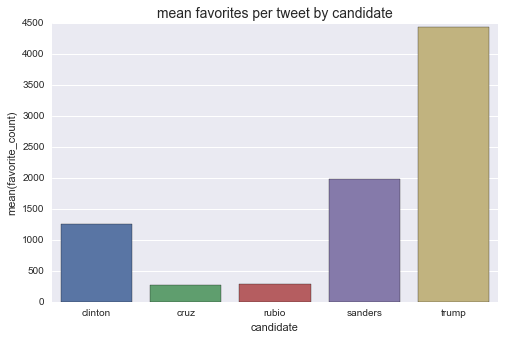

In [119]:
plt.figure(figsize = (8, 5))
sns.barplot(favs.index, 'favorite_count', data = favs)
plt.title('mean favorites per tweet by candidate', fontsize = 14)
plt.show()

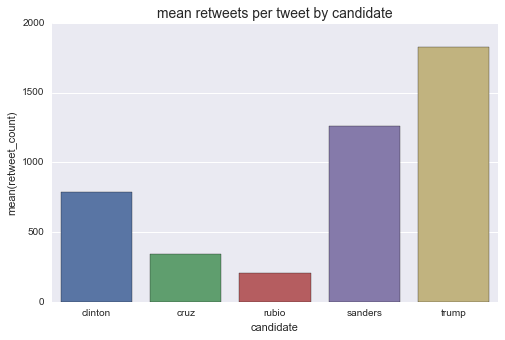

In [120]:
plt.figure(figsize = (8, 5))
sns.barplot(favs.index, 'retweet_count', data = favs)
plt.title('mean retweets per tweet by candidate', fontsize = 14)
plt.show()

###  <a id='3'></a>3. Add nlp features

Add sentiment, modality, and mood scores.

In [144]:
# pattern/textblob sentiment reference: http://www.clips.ua.ac.be/pages/pattern-en#sentiment
"""
modality > 0.5 = fact
mood = indicative (fact, belief), imperative (command, warning), conditional (conjecture), subjunctive (wish, opinion)
sentiments = (polarity, subjectivity)
subjectivity = 0 is objective, 1 is subjective
"""


Define functions to tokenize.

In [7]:
def get_sentences(text):
    sents = sent_tokenize(text)
    return [sent for sent in sents if re.search('[a-zA-Z]', sent) != None]

In [193]:
def get_polarity(sents):
    """Return polarity score for each sentence in text."""
    return [sentiment(x)[0] for x in sents]

def get_subjectivity(sents):
    """Return subjectivity score for each sentence in text."""
    return [sentiment(x)[1] for x in sents]

def get_is_fact(sents):
    """Return modality score for each sentence in text."""
    return [modality(x) for x in sents]

def get_mood(sents):
    """Return modality score for each sentence in text."""
    return [mood(x) for x in sents]

def get_mood_mode(mood):
    """Return most commonly occuring modality score for each tweet."""
    try:
        return stats.mode(mood)[0][0]
    except:
        return mood

In [8]:
# def get_polarity(sents):
#     """Returns average polarity score for sentences in text."""
#     return np.mean([sentiment(x)[0] for x in sents])

# def get_subjectivity(sents):
#     return np.mean([sentiment(x)[1] for x in sents])

# def get_is_fact(sents):
#     """Returns average modality score for sentences in text."""
#     return np.mean([modality(x) for x in sents])

In [239]:
# def tokenize_only(text):
#     # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
#     tokens = [word.lower() for sent in sent_tokenize(text) for word in word_tokenize(sent)]
#     filtered_tokens = []
#     # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
#     for token in tokens:
#         if re.search('[a-zA-Z]', token):
#             filtered_tokens.append(token)
#     return filtered_tokens

In [436]:
# get hashtags and mentions
def get_hashtags(entities):
    """Return a list of all hashtags used in tweet."""
    try:
        return {entities['hashtags'][i]['text'] for i in range(len(entities['hashtags']))}
    except:
        return 

def get_user_mentions(entities):
    """Return a list of all user mentions in tweet."""
    try:
        return {entities['user_mentions'][i]['screen_name'] for i in range(len(entities['user_mentions']))}
    except:
        return

def has_media(entities):
    """Return type of media if tweet contains media, blank if not."""
    try:
        return entities['media'][0]['type']
    except:
        return

In [467]:
# def get_clean_tokens(text):  
#     """Return tokens for each review; exclude stop words and lemmatize."""
#     # letters_only = re.sub("[^a-zA-Z]", " ", text) 
#     words = ' '.join(text.lower().split())
#     #words = ' '.join(split_text.lower().split())
#     tokens = [token.lemma_ for token in nlp(words)]
#     filtered = [t for t in tokens if t not in stop and t != '' and t != ' ' and t != '\n' and t != '\n\n']
#     return ' '.join(filtered)

def get_tokens(text):  
    """Return lemmatized tokens for each review."""
    text = re.sub(r"http\S+", "hyperlink", text) # replace urls with str hyperlink
    letters_only = re.sub("[^a-zA-Z0-9@]", " ", text) # remove everything except numbers, hashtags, and @
#     letters_only = re.sub("[^a-zA-Z]", " ", text) # remove non alpha characters
    words = ' '.join(letters_only.lower().split())
    try:
        tokens = [token.lemma_ for token in nlp(words)] # get lemmas
    except:
        tokens = [token.lemma_ for token in nlp(words.decode('utf8'))] # get lemmas
    filtered = [t for t in tokens if t != '' and t != ' ' and t != '\n' and t != '\n\n'] # remove any remaining spaces
    filtered = [t for t in filtered if any(letter.isalpha() for letter in t)] # remove numbers without any letters attached
    return ' '.join(filtered)

In [435]:
def get_features(df):
    # add sentences
    %time df.loc[:, 'sentences'] = df.loc[:, 'text'].apply(get_sentences)
    
    # add tokens
    %time df.loc[:, 'tokens'] = df.loc[:, 'text'].apply(get_tokens)
    
    # add sentiment, subjectivity, modality, and mood scores by sentence
    %time df.loc[:, 'sentiment'] = df.loc[:, 'sentences'].apply(get_polarity)
    %time df.loc[:, 'mood'] = df.loc[:, 'sentences'].apply(get_mood)
    %time df.loc[:, 'modality'] = df.loc[:, 'sentences'].apply(get_is_fact)
    %time df.loc[:, 'subjectivity'] = df.loc[:, 'sentences'].apply(get_subjectivity)
    
    # average the above scores
    %time df.loc[:, 'avg_sentiment'] = df.loc[:, 'sentiment'].apply(np.mean)
    %time df.loc[:, 'mode_mood'] = df.loc[:, 'mood'].apply(get_mood_mode)
    %time df.loc[:, 'avg_modality'] = df.loc[:, 'modality'].apply(np.mean)
    %time df.loc[:, 'avg_subjectivity'] = df.loc[:, 'subjectivity'].apply(np.mean)
    
    # count number of tokens
    df.loc[:, 'num_tokens'] = df.loc[:, 'tokens'].apply(lambda x: len(x.split()))
    
    # count number of characters
    df.loc[:, 'num_chars'] = df.loc[:, 'tokens'].apply(lambda x: len(x))
    
    # add user mentions, hashtags, and media
    df.loc[:, 'hashtags'] = df.loc[:, 'entities'].apply(get_hashtags)
    df.loc[:, 'user_mentions'] = df.loc[:, 'entities'].apply(get_user_mentions)
    df.loc[:, 'media'] = df.loc[:, 'entities'].apply(has_media)

    return df

In [465]:
def get_features2(df):
    %time df.loc[:, 'tokens'] = df.loc[:, 'text'].apply(get_tokens)

In [11]:
nlp = English()

In [342]:
stop = STOPWORDS
punct = {p for p in string.punctuation if p != '@' and p != '#'}

#### Process tweets df.

In [437]:
get_features(tweets)

CPU times: user 2.08 s, sys: 650 ms, total: 2.73 s
Wall time: 3.47 s
CPU times: user 27.9 s, sys: 3.34 s, total: 31.2 s
Wall time: 35.1 s
CPU times: user 5.74 s, sys: 236 ms, total: 5.98 s
Wall time: 6.7 s
CPU times: user 57.6 s, sys: 1.31 s, total: 58.9 s
Wall time: 1min
CPU times: user 1min 4s, sys: 1.05 s, total: 1min 5s
Wall time: 1min 7s
CPU times: user 6.04 s, sys: 176 ms, total: 6.22 s
Wall time: 6.75 s
CPU times: user 259 ms, sys: 18 ms, total: 277 ms
Wall time: 302 ms
CPU times: user 8.72 s, sys: 240 ms, total: 8.96 s
Wall time: 9.37 s
CPU times: user 207 ms, sys: 7.04 ms, total: 214 ms
Wall time: 222 ms
CPU times: user 263 ms, sys: 12.3 ms, total: 276 ms
Wall time: 321 ms


,id,created_at,text,favorite_count,retweet_count,coordinates,place,is_quote_status,quoted_status,quoted_status_id,...,subjectivity,avg_sentiment,mode_mood,avg_modality,avg_subjectivity,num_tokens,num_chars,hashtags,user_mentions,media
0,704339457974132736,Mon Feb 29 16:16:27 +0000 2016,#Trump2016 #TrumpInstagram: https://t.co/tzHtn...,973,454,None,None,False,NaN,NaN,...,[0.0],0.000000,indicative,0.750000,0.000000,6,48,"{TrumpInstagram, Trump2016}",{},photo
1,704332561296855040,Mon Feb 29 15:49:03 +0000 2016,I am self funding my campaign and only work fo...,3004,1114,None,None,False,NaN,NaN,...,"[0.5, 0.0]",0.000000,indicative,0.500000,0.250000,19,106,{Trump2016},{},photo
2,704324651384762368,Mon Feb 29 15:17:37 +0000 2016,"""Hillary could lose to Trump in Democratic New...",3750,1424,None,None,False,NaN,NaN,...,[0.454545454545],0.136364,conditional,0.178571,0.454545,14,96,"{Trump2016, MakeAmericaGreatAgain}",{},None
3,704312346706124800,Mon Feb 29 14:28:43 +0000 2016,"Join me in Columbus, Ohio tomorrow!\n#MakeAmer...",3459,1178,None,None,False,NaN,NaN,...,"[0.0, 0.0]",0.000000,imperative,0.875000,0.000000,11,79,"{Trump2016, MakeAmericaGreatAgain}",{},None
4,704285794643668992,Mon Feb 29 12:43:13 +0000 2016,Thank you America! Get out &amp; VOTE tomorrow...,6101,2303,None,None,False,NaN,NaN,...,"[0.0, 0.0, 0.0]",0.000000,imperative,0.833333,0.000000,14,99,"{MakeAmericaGreatAgain, Trump2016}",{},photo
5,704284013461180416,Mon Feb 29 12:36:08 +0000 2016,"My sons, Don and Eric, are on @foxandfriends n...",4947,974,None,None,False,NaN,NaN,...,"[0.0, 0.625]",0.325000,indicative,0.708333,0.312500,14,64,{},{foxandfriends},None
6,704111284095225856,Mon Feb 29 01:09:46 +0000 2016,Thank you @SenatorSessions!\n#MakeAmericaGreat...,10226,3903,None,None,False,NaN,NaN,...,"[0.0, 0.0]",0.000000,imperative,0.875000,0.000000,9,81,"{Trump2016, MakeAmericaGreatAgain}",{SenatorSessions},photo
7,704100078743625729,Mon Feb 29 00:25:14 +0000 2016,"THANK YOU ALABAMA! 32,000 supporters tonight. ...",14880,6019,None,None,False,NaN,NaN,...,"[0.0, 0.0, 0.0, 0.75, 0.0]",0.200000,imperative,0.850000,0.150000,20,113,{},{},photo
8,704064261413273601,Sun Feb 28 22:02:55 +0000 2016,Our law enforcement officers deserve our appre...,12093,4444,None,None,False,NaN,NaN,...,"[0.9, 0.0]",0.450000,imperative,0.625000,0.450000,16,109,{},{},photo
9,704062727082385409,Sun Feb 28 21:56:49 +0000 2016,I will be making a big surprise announcement t...,11739,3771,None,None,False,NaN,NaN,...,"[0.55, 0.0, 0.0]",0.000000,indicative,0.833333,0.183333,21,126,{Trump2016},{},None


In [468]:
get_features2(tweets)

CPU times: user 29.5 s, sys: 3.24 s, total: 32.7 s
Wall time: 37 s


In [477]:
# pickle
with open('pickled/tweetsdf.pkl', 'w') as picklefile:
    pickle.dump(tweets, picklefile)

In [470]:
# limit to only tweets longer than 75 characters
long_tweets = tweets[tweets.num_chars > 75]

#### Process transcripts

In [80]:
with open('transcripts/dem_debates.pkl', 'r') as picklefile:
    dem_debates = pickle.load(picklefile)
    
dem_debates_df = pd.DataFrame(dem_debates)
dem_debates_df = get_features(dem_debates_df)

CPU times: user 231 ms, sys: 1.8 ms, total: 232 ms
Wall time: 234 ms
CPU times: user 7.43 s, sys: 64.9 ms, total: 7.49 s
Wall time: 7.55 s
CPU times: user 1.27 s, sys: 23.9 ms, total: 1.29 s
Wall time: 1.29 s
CPU times: user 14.1 s, sys: 140 ms, total: 14.3 s
Wall time: 14.7 s
CPU times: user 16.8 s, sys: 262 ms, total: 17.1 s
Wall time: 17.7 s
CPU times: user 1.45 s, sys: 22.7 ms, total: 1.47 s
Wall time: 1.53 s
CPU times: user 12.5 ms, sys: 37 µs, total: 12.5 ms
Wall time: 12.7 ms
CPU times: user 448 ms, sys: 12.5 ms, total: 460 ms
Wall time: 552 ms
CPU times: user 10.7 ms, sys: 80 µs, total: 10.8 ms
Wall time: 10.9 ms
CPU times: user 9.34 ms, sys: 137 µs, total: 9.47 ms
Wall time: 9.67 ms


In [81]:
# drop weird row 
dem_debates_df = dem_debates_df[(dem_debates_df.candidate == 'CLINTON') | (dem_debates_df.candidate == 'SANDERS')]

In [42]:
with open('transcripts/gop_debates.pkl', 'r') as picklefile:
    gop_debates = pickle.load(picklefile)
    
gop_debates_df = pd.DataFrame(gop_debates)
gop_debates_df = get_features(gop_debates_df)

### Compare candidate subjectivity, mood, and modality

#### Tweets

In [201]:
by_cand = long_tweets.groupby('candidate')

In [202]:
by_cand.mean()

,id,favorite_count,retweet_count,is_quote_status,quoted_status_id,in_reply_to_status_id,avg_sentiment,avg_modality,avg_subjectivity,num_tokens,num_chars
candidate,,,,,,,,,,,
clinton,6.697053e+17,1163.327573,757.445405,0.034171,6.613461e+17,6.643644e+17,0.077618,0.745085,0.200789,18.905734,105.082875
cruz,6.861209e+17,260.196684,375.994473,0.039613,6.771974e+17,6.720707e+17,0.086275,0.741716,0.204096,17.780746,101.609857
rubio,6.508020e+17,297.696158,203.323054,0.011628,6.599023e+17,6.550809e+17,0.124329,0.725696,0.239222,18.045501,99.455005
sanders,6.807950e+17,2006.887264,1245.327149,0.020335,6.715115e+17,6.886256e+17,0.060697,0.728225,0.220332,19.101320,107.463075
trump,6.719054e+17,4489.297940,1840.806260,0.017433,6.671639e+17,NaN,0.122687,0.694728,0.362980,19.754358,110.729002


In [159]:
subjectivity = by_cand['avg_subjectivity'].mean()
subjectivity

candidate
clinton    0.200789
cruz       0.204096
rubio      0.239222
sanders    0.220332
trump      0.362980
Name: avg_subjectivity, dtype: float64

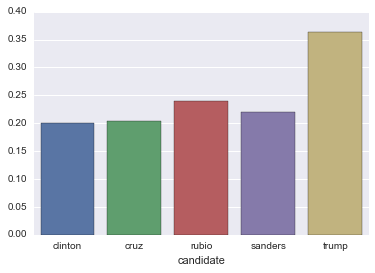

In [162]:
sns.barplot(subjectivity.index, subjectivity.values)

Sentiment

In [163]:
total_sentiment = by_cand['avg_sentiment'].sum()
total_sentiment

candidate
clinton    197.616368
cruz       187.302711
rubio      245.923086
sanders    170.133349
trump      309.661053
Name: avg_sentiment, dtype: float64

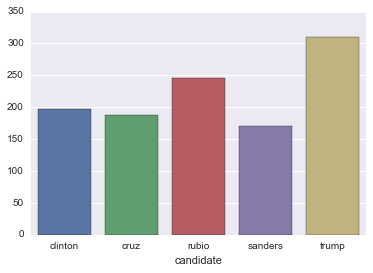

In [164]:
sns.barplot(total_sentiment.index, total_sentiment.values)

In [165]:
avg_sentiment = by_cand['avg_sentiment'].mean()
avg_sentiment

candidate
clinton    0.077618
cruz       0.086275
rubio      0.124329
sanders    0.060697
trump      0.122687
Name: avg_sentiment, dtype: float64

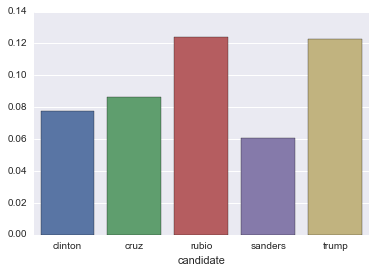

In [166]:
sns.barplot(avg_sentiment.index, avg_sentiment.values)

Investigate mood

In [171]:
long_tweets.head()

,id,created_at,text,favorite_count,retweet_count,coordinates,place,is_quote_status,quoted_status,quoted_status_id,...,sentiment,mood,modality,subjectivity,avg_sentiment,mode_mood,avg_modality,avg_subjectivity,num_tokens,num_chars
1,704332561296855040,Mon Feb 29 15:49:03 +0000 2016,I am self funding my campaign and only work fo...,3004,1114,None,None,False,NaN,NaN,...,"[0.0, 0.0]","[indicative, indicative]","[0.25, 0.75]","[0.5, 0.0]",0.000000,"([indicative], [2])",0.500000,0.250000,16,80
2,704324651384762368,Mon Feb 29 15:17:37 +0000 2016,"""Hillary could lose to Trump in Democratic New...",3750,1424,None,None,False,NaN,NaN,...,[0.136363636364],[conditional],[0.178571428571],[0.454545454545],0.136364,"([conditional], [1])",0.178571,0.454545,11,78
7,704100078743625729,Mon Feb 29 00:25:14 +0000 2016,"THANK YOU ALABAMA! 32,000 supporters tonight. ...",14880,6019,None,None,False,NaN,NaN,...,"[0.0, 0.0, 0.0, 1.0, 0.0]","[imperative, indicative, imperative, condition...","[1.0, 0.75, 0.75, 0.75, 1.0]","[0.0, 0.0, 0.0, 0.75, 0.0]",0.200000,"([imperative], [2])",0.850000,0.150000,17,96
8,704064261413273601,Sun Feb 28 22:02:55 +0000 2016,Our law enforcement officers deserve our appre...,12093,4444,None,None,False,NaN,NaN,...,"[0.9, 0.0]","[imperative, indicative]","[0.5, 0.75]","[0.9, 0.0]",0.450000,"([imperative], [1])",0.625000,0.450000,14,89
9,704062727082385409,Sun Feb 28 21:56:49 +0000 2016,I will be making a big surprise announcement t...,11739,3771,None,None,False,NaN,NaN,...,"[0.0, 0.0, 0.0]","[conditional, indicative, indicative]","[0.75, 1.0, 0.75]","[0.55, 0.0, 0.0]",0.000000,"([indicative], [2])",0.833333,0.183333,20,120


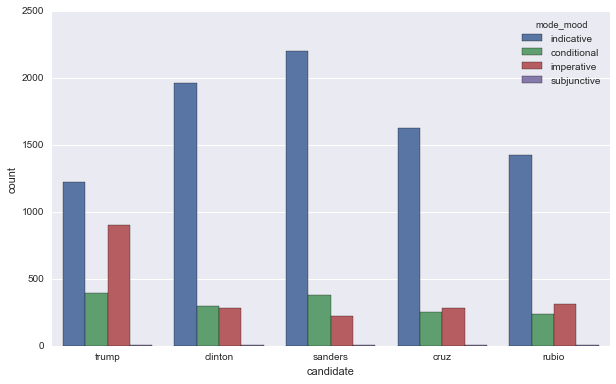

In [203]:
plt.figure(figsize = (10, 6))
sns.countplot('candidate', data = long_tweets, hue = 'mode_mood')

#### Debate transcripts

In [83]:
dem_deb_by_cand = dem_debates_df.groupby('candidate')

How has % speaking time during the debates changed over time?

In [86]:
dem_debates_df.head()

,candidate,date,text,sentences,tokens,sentiment,mood,modality,subjectivity,avg_sentiment,mode_mood,avg_modality,avg_subjectivity
0,SANDERS,2015-10-13,"Anderson, thank you very much. I think most Am...","[Anderson, thank you very much., I think most ...",anderson thank you very much i think most amer...,"[0.26, 0.55, 0.0, -0.112727272727, -0.04523809...","[indicative, indicative, indicative, indicativ...","[1.0, 0.5, 0.75, 0.25, 0.4375, 0.571428571429,...","[0.26, 0.7, 0.0333333333333, 0.550909090909, 0...",0.114464,"([indicative], [9])",0.646508,0.271040
1,CLINTON,2015-10-13,"Well, thank you, and thanks to everyone for ho...","[Well, thank you, and thanks to everyone for h...",well thank you and thanks to everyone for host...,"[0.225, 0.395454545455, 1.0, 0.45, 0.039671717...","[indicative, indicative, indicative, indicativ...","[1.0, 1.0, 1.0, 0.583333333333, 0.25, 1.0, 1.0...","[0.266666666667, 0.59595959596, 1.0, 0.6444444...",0.280997,"([indicative], [16])",0.697305,0.499849
2,CLINTON,2015-10-13,"Well, actually, I have been very consistent. O...","[Well, actually, I have been very consistent.,...",well actually i have be very consistent over t...,"[0.1625, 0.127272727273, 0.0, 0.0, 0.0, 0.4454...","[indicative, indicative, imperative, condition...","[1.0, 0.625, 0.75, -0.107142857143, 0.25, 0.5,...","[0.2125, 0.360909090909, 0.0, 0.0, 0.533333333...",0.122955,"([conditional], [5])",0.320166,0.281035
3,CLINTON,2015-10-13,"No. I think that, like most people that I know...","[No., I think that, like most people that I kn...",no i think that like most people that i know i...,"[0.0, 0.5, 0.24]","[indicative, indicative, imperative]","[1.0, 0.375, 0.5]","[0.0, 0.5, 0.501111111111]",0.246667,"([indicative], [2])",0.625000,0.333704
4,CLINTON,2015-10-13,I'm a progressive. But I'm a progressive who l...,"[I'm a progressive., But I'm a progressive who...",i m a progressive but i m a progressive who li...,"[0.0, 0.0, 0.333333333333, 0.0]","[indicative, indicative, indicative, indicative]","[1.0, 1.0, 0.522727272727, 0.625]","[0.0, 0.0, 0.666666666667, 0.0]",0.083333,"([indicative], [4])",0.786932,0.166667


In [84]:
dem_deb_by_cand.mean()

,avg_sentiment,avg_modality,avg_subjectivity
candidate,,,
CLINTON,0.086523,0.559459,0.276936
SANDERS,0.064811,0.642699,0.257157


### <a id='4'></a>4. Get tf-idf matrix / max counts

In [357]:
cand_stopwords = {'clinton': {u'hillary', u'clinton', u'hillaryclinton'}, 
                  'sanders': {u'bernie', u'sanders', u'berniesanders', u'feelthebern', u'sander'},
                  'cruz' : {u'ted', u'cruz', u'tedcruz', u'cruzcrew'},
                  'rubio' : {u'marco', u'rubio', u'marcorubio', u'teammarco'}, 
                  'trump' : {u'donald', u'trump', u'donaldtrump', u'realdonaldtrump', u'makeamericagreatagain'}}

In [356]:
# add general stopwords
stop = stop.union({u'rt', u'amp'})

In [26]:
candidates = ['clinton', 'sanders', 'trump', 'cruz', 'rubio']

In [420]:
# count_vectorizer = CountVectorizer(analyzer = "word",   \
#                              tokenizer = None,    \
#                              preprocessor = None, \
#                              stop_words = 'english', \
#                              max_features = 500) 

In [27]:
# tfidf_vectorizer = TfidfVectorizer(max_df = 0.7, max_features = 200000,
#                                  min_df = 5, stop_words = 'english',
#                                  use_idf = True, tokenizer = None, ngram_range=(3, 3))

In [204]:
def get_word_counts(cand, df):
    count_vect = CountVectorizer(analyzer = "word", 
                                       tokenizer = None, 
                                       preprocessor = None, 
                                       stop_words = stop.union(cand_stopwords[cand]), 
                                       max_features = 1000,
                                       ngram_range = (3, 3), 
                                       min_df = 3) 
    matrix = count_vect.fit_transform(df[df.candidate == cand].tokens)
    grams = count_vect.get_feature_names()
    dist = np.sum(matrix.toarray(), axis = 0)
    grams_sorted = sorted(zip(grams, dist), key = lambda x: x[1], reverse = True)[:10]
    print '\n', cand, '\n'
    print grams_sorted

In [205]:
for c in candidates:
    get_word_counts(c, long_tweets)


clinton 

[(u'comprehensive immigration reform', 12), (u'affordable care act', 10), (u'president united state', 10), (u'access health care', 8), (u'affordable health care', 8), (u'attack woman health', 8), (u'gun violence prevention', 8), (u'hillaryfornh watch live', 8), (u'right human right', 8), (u'supreme court justice', 8)]

sanders 

[(u'health care right', 20), (u'need political revolution', 15), (u'democratic socialism mean', 13), (u'public college university', 13), (u'create economy work', 12), (u'family medical leave', 12), (u'guarantee health care', 12), (u'issue face nation', 12), (u'university tuition free', 12), (u'college university tuition', 11)]

trump 

[(u'weak illegal immigration', 14), (u'book cripple america', 12), (u'saturday night live', 12), (u'self fund campaign', 10), (u'new cnn poll', 8), (u'wall street journal', 8), (u'want america great', 8), (u'byronyork cbsnews cnn', 6), (u'copy cripple america', 6), (u'morning joe foxnews', 6)]

cruz 

[(u'radical islam

### <a id='5'></a>5. kmeans clustering 

In [243]:
def get_clusters_counts(cand, df, true_k = 5):
    count_vect = CountVectorizer(analyzer = "word", 
                                       tokenizer = None, 
                                       preprocessor = None, 
                                       stop_words = cand_stopwords, 
                                       max_features = 20000,
                                       ngram_range = (1, 3), 
                                       min_df = 3) 
    matrix = count_vect.fit_transform(df[df.candidate == cand].tokens)
    grams = count_vect.get_feature_names()
    km = KMeans(n_clusters = true_k)
    km.fit(matrix)
    clusters = km.labels_.tolist()
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]
    print '\n', cand
    for i in range(true_k):
        print "\nCluster %d:" % i
        print ', '.join([grams[ind] for ind in order_centroids[i, :25]]) 
    return km

In [245]:
def get_clusters_tfidf(cand, df, true_k = 5):
    """Fit kmeans cluster model and print clusters given text vector. Return model."""
    vect = TfidfVectorizer(max_df = 0.5, max_features = 200000,
                                 min_df = 5, stop_words = cand_stopwords,
                                 use_idf = True, tokenizer = None, ngram_range=(1, 3))
    matrix = vect.fit_transform(df[df.candidate == cand].tokens) 
    terms = vect.get_feature_names()
    km = KMeans(n_clusters = true_k)
    km.fit(matrix)
    clusters = km.labels_.tolist()
    order_centroids = km.cluster_centers_.argsort()[:, ::-1]
#     print '\n', cand
#     for i in range(true_k):
#         print "\nCluster %d:" % i
#         print ', '.join([terms[ind] for ind in order_centroids[i, :25]]) 
    return km

#### without tfidf

In [244]:
clinton_model = get_clusters_counts('clinton', long_tweets, 50)


clinton

Cluster 0:
community, black, flint, lsd, esq, lsd esq, help, american, demdebate, america, ensure, racial, sow, insult, year, raid, end, fear, lorellapraeli, hand, strength, economic, hold accountable, hold, thanks

Cluster 1:
support, proud, american, stand, campaign, proud support, candidate, support campaign, presidential, fight, thank, need, plan, talk, raise, presidential candidate, woman, need support, today, hbcus, grateful support, business, grateful, tonight, time

Cluster 2:
country, american, president, economy, family, people, serve, muslim, american country, muslim american, wrong, job, muslim american country, economy country, proud, change, fight, need, immigration, better, strengthen, gopdebate, adam, united state, country better

Cluster 3:
health, care, affordable, affordable health, affordable health care, health care, quality affordable, quality, quality affordable health, right, human right, human, standwithpp, proud, fight, basic, proud standwithpp, amer

In [216]:
clinton_model.cluster_centers_.shape

(6, 1000)

In [239]:
# plot k vs. intertia
inertias = []
for k in range(1, 51):
    mod = get_clusters_counts('clinton', long_tweets, k)
    inertias.append(mod.inertia_)

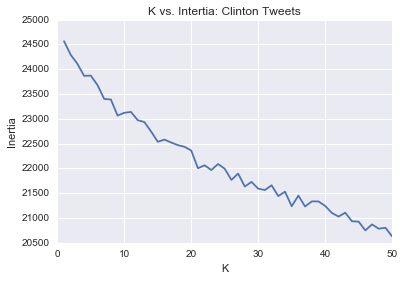

In [241]:
plt.plot(range(1,51), inertias)
plt.title('K vs. Intertia: Clinton Tweets')
plt.xlabel('K')
plt.ylabel('Inertia')
plt.show()

In [229]:
clinton_model.inertia_

23692.854116870232

In [228]:
for c in candidates:
    get_clusters_counts(c, long_tweets, true_k = 6)


clinton

Cluster 0:
president, need, demdebate, republican, obama, president obama, need president, woman, state, america, family, country, united, republican president, thebriefing, gun, like, gop, job, billclinton, united state, want, president united state, vote, run president

Cluster 1:
change, climate, climate change, real, act, fight, climate change real, change real, know, president, gopdebate, people, scientist, threaten, need, afford president, afford, republican, discuss, shape, life, candidate, sit, need act, threat

Cluster 2:
gun, violence, gun violence, protect, act, time, family, plan, prevention, community, gun violence prevention, violence prevention, act gun, protect family, act gun violence, better, prevent, family community, end, amendment, time act, stand, demdebate, prevent gun violence, prevent gun

Cluster 3:
right, woman, vote, woman right, fight, voting, human right, human, need, voting right, equal, vote right, protect, reproductive, reproductive right, lgb

#### with tfidf

In [246]:
tfidf_inertias = []
for k in range(1, 51):
    mod = get_clusters_tfidf('clinton', long_tweets, k)
    tfidf_inertias.append(mod.inertia_)

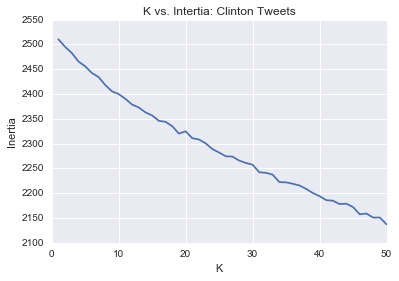

In [248]:
plt.plot(range(1,51), tfidf_inertias)
plt.title('K vs. Intertia: Clinton Tweets')
plt.xlabel('K')
plt.ylabel('Inertia')
plt.show()

In [92]:
cluster_dict = {cand : 3 for cand in candidates}

In [93]:
cluster_dict

{'clinton': 3, 'cruz': 3, 'rubio': 3, 'sanders': 3, 'trump': 3}

In [94]:
for c in cluster_dict:
    get_clusters_tfidf(c, long_tweets, true_k = cluster_dict[c])


sanders

Cluster 0:
sander, campaign, live, need, today, new, family, iowa, country, watch, political, american, demdebate, work, join, win, time, america, president, pay, revolution, right, stand, vote, woman

Cluster 1:
people, change, health, care, health care, american, climate change, climate, country, million, campaign, american people, need, real, political, young people, real change, right, million people, stand, young, care right, health care right, want, come

Cluster 2:
wall street, street, wall, greed, big, breakemup, bank, bail, billionaire, class, economy, money, fraud, model wall, business model wall, business model, kid, model, reform, free, debatewithbernie, campaign, administration, behavior, illegal

cruz

Cluster 0:
iowa, president, caucusforcruz, gopdebate, watch, today, support, win, live, new, rally, iacaucus, campaign, vote, conservative, cruzintocaucus, listen, endorse, great, cruztovictory, choosecruz, glennbeck, day, ad, speak

Cluster 1:
join, et, tune, pm,

### <a id='6'></a>6. topic modeling 

In [37]:
def print_top_words(model, feature_names, n_top_words = 20):
    for topic_idx, topic in enumerate(model.components_):
        print "\nTopic #%d:" % topic_idx
        print ", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])

In [478]:
def get_cand_tokens(cand, df):
    return df[df.candidate == cand].tokens

In [483]:
def get_topics_lda_by_cand(cand, df, n_topics = 4):   
    docs = df[df.candidate == cand].tokens
    count_vect = CountVectorizer(analyzer = "word", 
                                       tokenizer = None, 
                                       preprocessor = None, 
                                       stop_words = stop.union(cand_stopwords[cand]), 
                                       max_features = 10000,
                                       ngram_range = (1, 3), 
                                       min_df = 5) 
    matrix = count_vect.fit_transform(docs)
    vocab = count_vect.get_feature_names()
    
    # fit transform lda
    lda = LatentDirichletAllocation(n_topics=n_topics, max_iter=5,
                learning_method='online', learning_offset=50.,
                random_state=0)
    doc_topic_dists = lda.fit_transform(matrix)
    
#     # print topic words
#     print "\nTopics in LDA model:", cand
#     print_top_words(lda, vocab)
    
    # prepare pyLDAvis stuff 
    get_normed = lambda data: pd.DataFrame(data).div(data.sum(axis = 1), axis = 0) 
    prepared = pyLDAvis.prepare(
            doc_lengths = docs.str.len(),
            vocab = vocab,
            term_frequency = np.asarray(matrix.sum(axis = 0)).ravel().tolist(),
            topic_term_dists = get_normed(lda.components_), # topics x terms 
            doc_topic_dists = get_normed(doc_topic_dists)) # docs x topics 
    
    return lda, doc_topic_dists, prepared

In [323]:
def get_doc_topics(doc_topic_dist):
    """Return list of topics for documents, given doc topic distribution"""
    return [np.argmax(topic) for doc, topic in enumerate(doc_topic_dist)]

In [484]:
trump_lda, trump_doc_topics, trump_prepared = get_topics_lda('trump', long_tweets, 5)

In [366]:
pyLDAvis.display(trump_prepared)

#### All candidates

In [492]:
def get_topics_lda(docs, df, n_topics = 4):   
    count_vect = CountVectorizer(analyzer = "word", 
                                       tokenizer = None, 
                                       preprocessor = None, 
                                       stop_words = stop, 
                                       max_features = 10000,
                                       ngram_range = (1, 3), 
                                       min_df = 5) 
    matrix = count_vect.fit_transform(docs)
    vocab = count_vect.get_feature_names()
    
    # fit transform lda
    lda = LatentDirichletAllocation(n_topics=n_topics, doc_topic_prior = .001, max_iter=5,
                learning_method='online', learning_offset=50.,
                random_state=0)
    doc_topic_dists = lda.fit_transform(matrix)
    
#     # print topic words
#     print "\nTopics in LDA model:", cand
#     print_top_words(lda, vocab)
    
    # prepare pyLDAvis stuff 
    get_normed = lambda data: pd.DataFrame(data).div(data.sum(axis = 1), axis = 0) 
    prepared = pyLDAvis.prepare(
            doc_lengths = docs.str.len(),
            vocab = vocab,
            term_frequency = np.asarray(matrix.sum(axis = 0)).ravel().tolist(),
            topic_term_dists = get_normed(lda.components_), # topics x terms 
            doc_topic_dists = get_normed(doc_topic_dists)) # docs x topics 
    
    return lda, doc_topic_dists, prepared

In [493]:
all_lda, all_doc_topics, all_prepared = get_topics_lda(long_tweets.tokens, long_tweets, 10)

In [494]:
pyLDAvis.display(all_prepared)